### PROBLEM STATEMENT
**• DOMAIN:** Automotive. Surveillance.<br/>
**• CONTEXT:**<br/>
Computer vision can be used to automate supervision and generate action appropriate action trigger if the event is
predicted from the image of interest. For example a car moving on the road can be easily identified by a camera as make of
the car, type, colour, number plates etc.<br/>
**• DATA DESCRIPTION:**<br/>
The Cars dataset contains 16,185 images of 196 classes of cars. The data is split into 8,144 training images and 8,041 testing
images, where each class has been split roughly in a 50-50 split. Classes are typically at the level of Make, Model, Year, e.g.
2012 Tesla Model S or 2012 BMW M3 coupe.<br/>
**Data description:**
‣ Train Images: Consists of real images of cars as per the make and year of the car.<br/>
‣ Test Images: Consists of real images of cars as per the make and year of the car.<br/>
‣ Train Annotation: Consists of bounding box region for training images.<br/>
‣ Test Annotation: Consists of bounding box region for testing images.<br/>

#### Milestone 1:

**Step 1: Import the data**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Loading train and test annotation csv files

In [2]:
train_anno_df=pd.read_csv('../input/cv2-csvs/Train Annotations.csv')
test_anno_df=pd.read_csv('../input/cv2-csvs/Test Annotation.csv')

In [3]:
train_anno_df.rename(columns={'Bounding Box coordinates': 'x0', 'Unnamed: 2': 'y0','Unnamed: 3': 'x1','Unnamed: 4': 'y1'}, inplace=True)
train_anno_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8144 entries, 0 to 8143
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Image Name   8144 non-null   object
 1   x0           8144 non-null   int64 
 2   y0           8144 non-null   int64 
 3   x1           8144 non-null   int64 
 4   y1           8144 non-null   int64 
 5   Image class  8144 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 381.9+ KB


In [4]:
train_anno_df.head(10)

,Image Name,x0,y0,x1,y1,Image class
0,00001.jpg,39,116,569,375,14
1,00002.jpg,36,116,868,587,3
2,00003.jpg,85,109,601,381,91
3,00004.jpg,621,393,1484,1096,134
4,00005.jpg,14,36,133,99,106
5,00006.jpg,259,289,515,416,123
6,00007.jpg,88,80,541,397,89
7,00008.jpg,73,79,591,410,96
8,00009.jpg,20,126,1269,771,167
9,00010.jpg,21,110,623,367,58


In [5]:
test_anno_df.rename(columns={'Bounding Box coordinates': 'x0', 'Unnamed: 2': 'y0','Unnamed: 3': 'x1','Unnamed: 4': 'y1'}, inplace=True)
test_anno_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8041 entries, 0 to 8040
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Image Name   8041 non-null   object
 1   x0           8041 non-null   int64 
 2   y0           8041 non-null   int64 
 3   x1           8041 non-null   int64 
 4   y1           8041 non-null   int64 
 5   Image class  8041 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 377.0+ KB


In [6]:
test_anno_df.head(10)

,Image Name,x0,y0,x1,y1,Image class
0,00001.jpg,30,52,246,147,181
1,00002.jpg,100,19,576,203,103
2,00003.jpg,51,105,968,659,145
3,00004.jpg,67,84,581,407,187
4,00005.jpg,140,151,593,339,185
5,00006.jpg,20,77,420,301,78
6,00007.jpg,249,166,2324,1459,118
7,00008.jpg,119,215,1153,719,165
8,00009.jpg,1,7,275,183,32
9,00010.jpg,28,55,241,177,60


### Step 2: Map training and testing images to its classes.

In [7]:
#Loading name of cars 
carNameDF= pd.read_csv("../input/stanford-car-dataset-by-classes-folder/names.csv",header=None)

In [8]:
carNameDF.shape

(196, 1)

In [9]:
carNameDF.head(10)

,0
0,AM General Hummer SUV 2000
1,Acura RL Sedan 2012
2,Acura TL Sedan 2012
3,Acura TL Type-S 2008
4,Acura TSX Sedan 2012
5,Acura Integra Type R 2001
6,Acura ZDX Hatchback 2012
7,Aston Martin V8 Vantage Convertible 2012
8,Aston Martin V8 Vantage Coupe 2012
9,Aston Martin Virage Convertible 2012


In [10]:
carNameDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       196 non-null    object
dtypes: object(1)
memory usage: 1.7+ KB


#### Function to create data frame with Image Name,Image np array,Car Make

In [11]:
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
CHANNEL=3

In [12]:
import os
import tensorflow
from keras.preprocessing import image
#from tqdm import tqdm
def createImageDF(imageSourceFolder,target_size_tuple,colormode,totalImagePerClassCap):
    dfRows=[]
    for dirname, _, filenames in os.walk(imageSourceFolder):
            limit=0
            if len(filenames) < totalImagePerClassCap:
                limit=len(filenames)
            else:
                limit=totalImagePerClassCap
            for i in range(0,limit):
                    processedRows=[]
                    filename=filenames[i]
                    processedRows.append(filename)
                    pathSplits=dirname.split('/')
                    #print(os.path.join(dirname, filename))
                    imgPath=os.path.join(dirname, filename)
                    #print(imgPath)
                    img = image.load_img(imgPath)
                    if target_size_tuple!='':
                        img_scaled = image.load_img(imgPath, target_size=target_size_tuple, color_mode = colormode)
                        image_width_scale_fact=target_size_tuple[0]/img.width
                        image_height_scale_fact=target_size_tuple[1]/img.height
                        imgArray = image.img_to_array(img_scaled)
                    else:
                        img
                        image_width_scale_fact=img.width
                        image_height_scale_fact=img.height
                        #img = Image.open(imgPath)
                        imgArray = image.img_to_array(img)
                    #imgArray=np.asarray(img)
                    processedRows.append(imgArray)
                    processedRows.append(pathSplits[len(pathSplits)-1])
                    processedRows.append(image_width_scale_fact)
                    processedRows.append(image_height_scale_fact)
                    dfRows.append(processedRows)
    return pd.DataFrame(dfRows, columns=["Image Name","image_array","model","image_width_scale_fact","image_height_scale_fact"])


In [13]:
def loadSingleScoringImage(imageSourcePath,target_size_tuple,colormode):
    dfRows=[]
    processedRow=[]
    imgPath=imageSourcePath
    img = image.load_img(imgPath)
    pathSplits=imgPath.split('/')
    if target_size_tuple!='':
        img_scaled = image.load_img(imgPath, target_size=target_size_tuple, color_mode = colormode)
        image_width_scale_fact=target_size_tuple[0]/img.width
        image_height_scale_fact=target_size_tuple[1]/img.height
        imgArray = image.img_to_array(img_scaled)
    else:
        img
        image_width_scale_fact=img.width
        image_height_scale_fact=img.height
        #img = Image.open(imgPath)
        imgArray = image.img_to_array(img)
    #imgArray=np.asarray(img)
    processedRow.append(pathSplits[len(pathSplits)-1])
    processedRow.append(imgArray)
    processedRow.append(pathSplits[len(pathSplits)-2])
    processedRow.append(image_width_scale_fact)
    processedRow.append(image_height_scale_fact)
    dfRows.append(processedRow)
    return pd.DataFrame(dfRows, columns=["Image Name","image_array","model","image_width_scale_fact","image_height_scale_fact"])

In [14]:
trainImageDF=createImageDF('../input/stanford-car-dataset-by-classes-folder/car_data/car_data/train','',"rgb",2)

In [15]:
trainImageDF.head(10)

,Image Name,image_array,model,image_width_scale_fact,image_height_scale_fact
0,01683.jpg,"[[[246.0, 255.0, 196.0], [235.0, 255.0, 216.0]...",Dodge Ram Pickup 3500 Crew Cab 2010,259,194
1,07380.jpg,"[[[81.0, 105.0, 131.0], [84.0, 105.0, 132.0], ...",Dodge Ram Pickup 3500 Crew Cab 2010,1024,768
2,07196.jpg,"[[[254.0, 254.0, 254.0], [253.0, 253.0, 253.0]...",Cadillac CTS-V Sedan 2012,700,467
3,01978.jpg,"[[[168.0, 164.0, 152.0], [193.0, 189.0, 177.0]...",Cadillac CTS-V Sedan 2012,256,170
4,02696.jpg,"[[[77.0, 80.0, 25.0], [77.0, 80.0, 25.0], [77....",Audi S5 Convertible 2012,276,183
5,06793.jpg,"[[[189.0, 176.0, 183.0], [189.0, 176.0, 183.0]...",Audi S5 Convertible 2012,259,194
6,01209.jpg,"[[[151.0, 161.0, 173.0], [155.0, 165.0, 177.0]...",Ram C-V Cargo Van Minivan 2012,120,120
7,00763.jpg,"[[[41.0, 40.0, 45.0], [42.0, 41.0, 46.0], [43....",Ram C-V Cargo Van Minivan 2012,640,426
8,01081.jpg,"[[[238.0, 241.0, 255.0], [239.0, 242.0, 255.0]...",smart fortwo Convertible 2012,300,225
9,02392.jpg,"[[[93.0, 92.0, 64.0], [94.0, 93.0, 65.0], [96....",smart fortwo Convertible 2012,212,123


In [16]:
# Lodaing annotation details for images from train_anno_df i.e. train annotations
trainMergedImageDF=pd.merge(trainImageDF,train_anno_df, on=['Image Name'])

In [17]:
trainMergedImageDF.head(10)

,Image Name,image_array,model,image_width_scale_fact,image_height_scale_fact,x0,y0,x1,y1,Image class
0,01683.jpg,"[[[246.0, 255.0, 196.0], [235.0, 255.0, 216.0]...",Dodge Ram Pickup 3500 Crew Cab 2010,259,194,19,55,244,160,86
1,07380.jpg,"[[[81.0, 105.0, 131.0], [84.0, 105.0, 132.0], ...",Dodge Ram Pickup 3500 Crew Cab 2010,1024,768,84,20,961,731,86
2,07196.jpg,"[[[254.0, 254.0, 254.0], [253.0, 253.0, 253.0]...",Cadillac CTS-V Sedan 2012,700,467,29,203,637,450,51
3,01978.jpg,"[[[168.0, 164.0, 152.0], [193.0, 189.0, 177.0]...",Cadillac CTS-V Sedan 2012,256,170,13,23,244,160,51
4,02696.jpg,"[[[77.0, 80.0, 25.0], [77.0, 80.0, 25.0], [77....",Audi S5 Convertible 2012,276,183,25,29,265,163,21
5,06793.jpg,"[[[189.0, 176.0, 183.0], [189.0, 176.0, 183.0]...",Audi S5 Convertible 2012,259,194,17,71,227,175,21
6,01209.jpg,"[[[151.0, 161.0, 173.0], [155.0, 165.0, 177.0]...",Ram C-V Cargo Van Minivan 2012,120,120,1,24,120,103,174
7,00763.jpg,"[[[41.0, 40.0, 45.0], [42.0, 41.0, 46.0], [43....",Ram C-V Cargo Van Minivan 2012,640,426,66,176,588,362,174
8,01081.jpg,"[[[238.0, 241.0, 255.0], [239.0, 242.0, 255.0]...",smart fortwo Convertible 2012,300,225,22,47,278,213,196
9,02392.jpg,"[[[93.0, 92.0, 64.0], [94.0, 93.0, 65.0], [96....",smart fortwo Convertible 2012,212,123,17,13,197,115,196


In [18]:
len(trainMergedImageDF)

392

**Function to create bounding box on image**

In [19]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def drowBoxedImages(dataFrame,featureCol,x0,y0,x1,y1,boxlinewidth,boxedgecolor):
  fig,ax=plt.subplots(len(dataFrame))
  fig.set_size_inches(15,15)
  # Display the image
  for index, row in dataFrame.iterrows():
    data=row[featureCol]
    img = image.array_to_img(data)
    ax[index].imshow(img)
    image_height, image_width, _ = data.shape
    rect=[]
    rect.append(patches.Rectangle((row[x0], row[y0]), row[x1] - row[x0], row[y1] - row[y0], linewidth=boxlinewidth, edgecolor=boxedgecolor, facecolor='none'))
    # Add the patch to the Axes
    for l in range(0,len(rect)):
      ax[index].add_patch(rect[l])
  plt.show()

In [20]:
def drowImages(dataFrame,featureCol):
  fig,ax=plt.subplots(len(dataFrame))
  fig.set_size_inches(15,15)
  # Display the image
  for index, row in dataFrame.iterrows():
    data=row[featureCol]
    img = image.array_to_img(data)
    ax[index].imshow(img)
  plt.show()

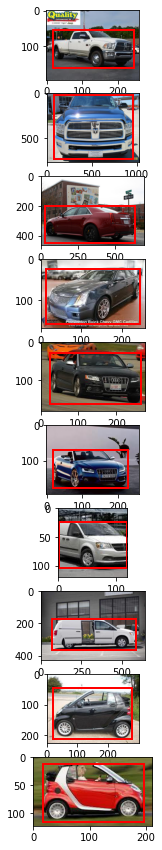

In [21]:
drowBoxedImages(trainMergedImageDF.head(10),'image_array','x0','y0','x1','y1',2,'r')

**For test data**

In [22]:
testImageDF=createImageDF('../input/stanford-car-dataset-by-classes-folder/car_data/car_data/test','',"rgb",2)

In [23]:
testImageDF.head(10)

,Image Name,image_array,model,image_width_scale_fact,image_height_scale_fact
0,04772.jpg,"[[[88.0, 88.0, 88.0], [65.0, 65.0, 65.0], [76....",Dodge Ram Pickup 3500 Crew Cab 2010,300,225
1,08033.jpg,"[[[33.0, 25.0, 22.0], [33.0, 25.0, 22.0], [33....",Dodge Ram Pickup 3500 Crew Cab 2010,1024,768
2,00091.jpg,"[[[188.0, 188.0, 188.0], [188.0, 188.0, 188.0]...",Cadillac CTS-V Sedan 2012,289,174
3,02184.jpg,"[[[47.0, 52.0, 45.0], [54.0, 59.0, 52.0], [37....",Cadillac CTS-V Sedan 2012,640,425
4,01001.jpg,"[[[173.0, 181.0, 158.0], [41.0, 49.0, 26.0], [...",Audi S5 Convertible 2012,280,180
5,06024.jpg,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...",Audi S5 Convertible 2012,284,177
6,00706.jpg,"[[[117.0, 128.0, 120.0], [120.0, 131.0, 123.0]...",Ram C-V Cargo Van Minivan 2012,300,225
7,02085.jpg,"[[[255.0, 255.0, 255.0], [255.0, 255.0, 255.0]...",Ram C-V Cargo Van Minivan 2012,259,194
8,00583.jpg,"[[[223.0, 224.0, 219.0], [224.0, 225.0, 220.0]...",smart fortwo Convertible 2012,500,340
9,02007.jpg,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",smart fortwo Convertible 2012,260,194


In [24]:
# Lodaing annotation details for images from train_anno_df i.e. train annotations
testMergedImageDF=pd.merge(testImageDF,test_anno_df, on=['Image Name'])

In [25]:
testMergedImageDF.head(10)

,Image Name,image_array,model,image_width_scale_fact,image_height_scale_fact,x0,y0,x1,y1,Image class
0,04772.jpg,"[[[88.0, 88.0, 88.0], [65.0, 65.0, 65.0], [76....",Dodge Ram Pickup 3500 Crew Cab 2010,300,225,18,51,291,209,86
1,08033.jpg,"[[[33.0, 25.0, 22.0], [33.0, 25.0, 22.0], [33....",Dodge Ram Pickup 3500 Crew Cab 2010,1024,768,216,110,903,590,86
2,00091.jpg,"[[[188.0, 188.0, 188.0], [188.0, 188.0, 188.0]...",Cadillac CTS-V Sedan 2012,289,174,47,38,259,155,51
3,02184.jpg,"[[[47.0, 52.0, 45.0], [54.0, 59.0, 52.0], [37....",Cadillac CTS-V Sedan 2012,640,425,15,71,610,334,51
4,01001.jpg,"[[[173.0, 181.0, 158.0], [41.0, 49.0, 26.0], [...",Audi S5 Convertible 2012,280,180,52,99,233,173,21
5,06024.jpg,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...",Audi S5 Convertible 2012,284,177,14,49,271,154,21
6,00706.jpg,"[[[117.0, 128.0, 120.0], [120.0, 131.0, 123.0]...",Ram C-V Cargo Van Minivan 2012,300,225,21,19,267,185,174
7,02085.jpg,"[[[255.0, 255.0, 255.0], [255.0, 255.0, 255.0]...",Ram C-V Cargo Van Minivan 2012,259,194,9,24,250,172,174
8,00583.jpg,"[[[223.0, 224.0, 219.0], [224.0, 225.0, 220.0]...",smart fortwo Convertible 2012,500,340,56,64,474,323,196
9,02007.jpg,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",smart fortwo Convertible 2012,260,194,36,32,235,166,196


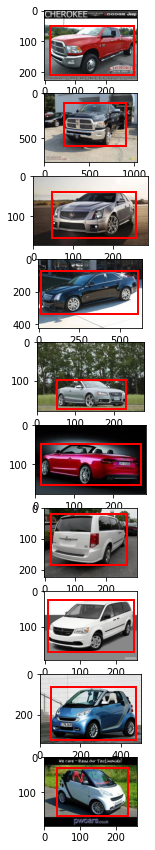

In [26]:
drowBoxedImages(testMergedImageDF.head(10),'image_array','x0','y0','x1','y1',2,'r')

### Let's check distribution of each class in our training data

<AxesSubplot:xlabel='Image class', ylabel='Count'>

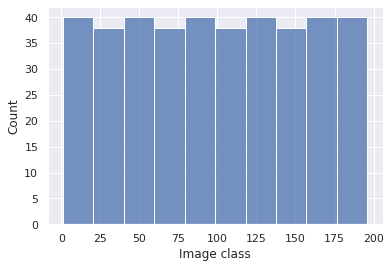

In [27]:
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.histplot(x= trainMergedImageDF['Image class'],bins = 10)

### From above histogram it is clear that we have almost equal density distribution among car classes in training data df

### Let's reduce size of training data set images

In [28]:
trainReducedImageDF=createImageDF('../input/stanford-car-dataset-by-classes-folder/car_data/car_data/train',(IMAGE_WIDTH,IMAGE_HEIGHT,CHANNEL),"rgb",5)

In [29]:
trainReducedImageDF.head(5)

,Image Name,image_array,model,image_width_scale_fact,image_height_scale_fact
0,01683.jpg,"[[[235.0, 255.0, 216.0], [228.0, 255.0, 255.0]...",Dodge Ram Pickup 3500 Crew Cab 2010,0.494208,0.659794
1,07380.jpg,"[[[93.0, 111.0, 133.0], [99.0, 110.0, 128.0], ...",Dodge Ram Pickup 3500 Crew Cab 2010,0.125000,0.166667
2,07101.jpg,"[[[255.0, 255.0, 255.0], [255.0, 255.0, 255.0]...",Dodge Ram Pickup 3500 Crew Cab 2010,0.266667,0.355556
3,01947.jpg,"[[[255.0, 255.0, 255.0], [255.0, 255.0, 255.0]...",Dodge Ram Pickup 3500 Crew Cab 2010,0.426667,0.426667
4,06748.jpg,"[[[241.0, 249.0, 251.0], [242.0, 251.0, 250.0]...",Dodge Ram Pickup 3500 Crew Cab 2010,0.426667,0.568889


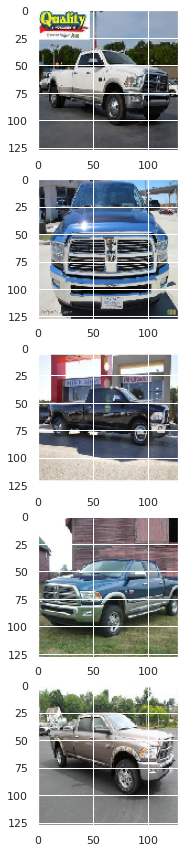

In [30]:
drowImages(trainReducedImageDF.head(5),'image_array')

In [31]:
# Lodaing annotation details for images from train_anno_df i.e. train annotations
trainReducedMergedImageDF=pd.merge(trainReducedImageDF,train_anno_df, on=['Image Name'])

In [32]:
trainReducedMergedImageDF.head()

,Image Name,image_array,model,image_width_scale_fact,image_height_scale_fact,x0,y0,x1,y1,Image class
0,01683.jpg,"[[[235.0, 255.0, 216.0], [228.0, 255.0, 255.0]...",Dodge Ram Pickup 3500 Crew Cab 2010,0.494208,0.659794,19,55,244,160,86
1,07380.jpg,"[[[93.0, 111.0, 133.0], [99.0, 110.0, 128.0], ...",Dodge Ram Pickup 3500 Crew Cab 2010,0.125000,0.166667,84,20,961,731,86
2,07101.jpg,"[[[255.0, 255.0, 255.0], [255.0, 255.0, 255.0]...",Dodge Ram Pickup 3500 Crew Cab 2010,0.266667,0.355556,34,100,454,250,86
3,01947.jpg,"[[[255.0, 255.0, 255.0], [255.0, 255.0, 255.0]...",Dodge Ram Pickup 3500 Crew Cab 2010,0.426667,0.426667,3,89,300,260,86
4,06748.jpg,"[[[241.0, 249.0, 251.0], [242.0, 251.0, 250.0]...",Dodge Ram Pickup 3500 Crew Cab 2010,0.426667,0.568889,15,36,290,181,86


#### Function to create scalled bounding boxes

In [33]:
def scaledBoundingBoxCreator(df):
    df['x0_scaled']=df.x0 *df.image_width_scale_fact
    df['y0_scaled']=df.y0*df.image_height_scale_fact
    df['x1_scaled']=df.x1*df.image_width_scale_fact
    df['y1_scaled']=df.y1*df.image_height_scale_fact
    df['x0_scaled']=df['x0_scaled'].apply(np.floor)
    df['y0_scaled']=df['y0_scaled'].apply(np.floor)
    df['x1_scaled']=df['x1_scaled'].apply(np.floor)
    df['y1_scaled']=df['y1_scaled'].apply(np.floor)

In [34]:
scaledBoundingBoxCreator(trainReducedMergedImageDF)

In [35]:
trainReducedMergedImageDF.head()

,Image Name,image_array,model,image_width_scale_fact,image_height_scale_fact,x0,y0,x1,y1,Image class,x0_scaled,y0_scaled,x1_scaled,y1_scaled
0,01683.jpg,"[[[235.0, 255.0, 216.0], [228.0, 255.0, 255.0]...",Dodge Ram Pickup 3500 Crew Cab 2010,0.494208,0.659794,19,55,244,160,86,9.0,36.0,120.0,105.0
1,07380.jpg,"[[[93.0, 111.0, 133.0], [99.0, 110.0, 128.0], ...",Dodge Ram Pickup 3500 Crew Cab 2010,0.125000,0.166667,84,20,961,731,86,10.0,3.0,120.0,121.0
2,07101.jpg,"[[[255.0, 255.0, 255.0], [255.0, 255.0, 255.0]...",Dodge Ram Pickup 3500 Crew Cab 2010,0.266667,0.355556,34,100,454,250,86,9.0,35.0,121.0,88.0
3,01947.jpg,"[[[255.0, 255.0, 255.0], [255.0, 255.0, 255.0]...",Dodge Ram Pickup 3500 Crew Cab 2010,0.426667,0.426667,3,89,300,260,86,1.0,37.0,128.0,110.0
4,06748.jpg,"[[[241.0, 249.0, 251.0], [242.0, 251.0, 250.0]...",Dodge Ram Pickup 3500 Crew Cab 2010,0.426667,0.568889,15,36,290,181,86,6.0,20.0,123.0,102.0


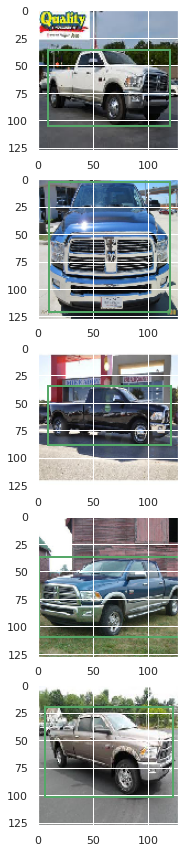

In [36]:
drowBoxedImages(trainReducedMergedImageDF.head(),'image_array','x0_scaled','y0_scaled','x1_scaled','y1_scaled',2,'g')

### Noramlizing image features as they are raingeing from 0 to 255

In [37]:
trainReducedMergedImageDF['image_array']=trainReducedMergedImageDF['image_array']/255

In [38]:
trainReducedMergedImageDF.head(2)

,Image Name,image_array,model,image_width_scale_fact,image_height_scale_fact,x0,y0,x1,y1,Image class,x0_scaled,y0_scaled,x1_scaled,y1_scaled
0,01683.jpg,"[[[0.92156863, 1.0, 0.84705883], [0.89411765, ...",Dodge Ram Pickup 3500 Crew Cab 2010,0.494208,0.659794,19,55,244,160,86,9.0,36.0,120.0,105.0
1,07380.jpg,"[[[0.3647059, 0.43529412, 0.52156866], [0.3882...",Dodge Ram Pickup 3500 Crew Cab 2010,0.125000,0.166667,84,20,961,731,86,10.0,3.0,120.0,121.0


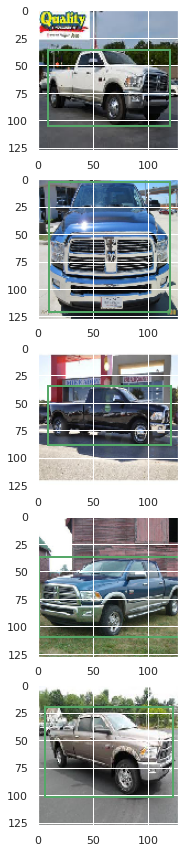

In [39]:
drowBoxedImages(trainReducedMergedImageDF.head(),'image_array','x0_scaled','y0_scaled','x1_scaled','y1_scaled',2,'g')

#### Creating reduced image size test data

In [40]:
testReducedImageDF=createImageDF('../input/stanford-car-dataset-by-classes-folder/car_data/car_data/test',(IMAGE_WIDTH,IMAGE_HEIGHT,CHANNEL),"grayscale",5)

In [41]:
# Lodaing annotation details for images from test_anno_df i.e. test annotations
testReducedMergedImageDF=pd.merge(testReducedImageDF,test_anno_df, on=['Image Name'])

In [42]:
scaledBoundingBoxCreator(testReducedMergedImageDF)

### Noramlizing image features as they are raingeing from 0 to 255

In [43]:
testReducedMergedImageDF['image_array']=testReducedMergedImageDF['image_array']/255

### Let's create X_train,y_train,x_test,y_test variables

In [44]:
testReducedMergedImageDF['image_array'].shape

(980,)

In [45]:
# Creating an empty tensor to store image arrays
def createFeatureTensor(dfCol):
    tensor = np.zeros((dfCol.shape[0],IMAGE_WIDTH,IMAGE_HEIGHT,CHANNEL))
    # Iterating through image arrays to update tensor
    for idx, i in enumerate(dfCol):
        tensor[idx] = i
    # Checking the tensor shape
    tensor.shape
    return tensor

In [46]:
# Creating an empty tensor to store image arrays
def createBondingBoxTensor(df,x0,y0,x1,y1):
    labelBox = []
    # Iterating through image arrays to update tensor
    for i in range(0,len(df[x0])):
        params=[]
        params.append(df[x0][i])
        params.append(df[y0][i])
        params.append(df[x1][i])
        params.append(df[y1][i])
        labelBox.append(params)
    return np.array(labelBox)

In [47]:
x_train = createFeatureTensor(trainReducedMergedImageDF['image_array'])
x_test = createFeatureTensor(testReducedMergedImageDF['image_array'])

In [48]:
x_train.shape

(980, 128, 128, 3)

### Creating lables for classification

In [49]:
y_train_classi=trainReducedMergedImageDF['Image class']
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
le=LabelEncoder()
y_train_tensor=le.fit_transform(y_train_classi)
y_train_tensor=to_categorical(y_train_tensor,196)


In [50]:
y_train_tensor.shape

(980, 196)

In [51]:
y_test_classi=testReducedMergedImageDF['Image class']
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
le=LabelEncoder()
y_test_tensor=le.fit_transform(y_test_classi)
y_test_tensor=to_categorical(y_test_tensor,196)

In [52]:
y_train_tensor[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [53]:
y_test_tensor.shape

(980, 196)

### Creating multiclass classifier CNN model

In [54]:
from tensorflow.keras.layers import Conv2D

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Dropout
from tensorflow.keras import regularizers, optimizers

nnmodel = Sequential()
#hidden_nodes=128
output_nodes=196 #As range of image labels is up to 196
nnmodel.add(Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,CHANNEL)))
nnmodel.add(Conv2D(filters=32, kernel_size=3, activation="relu"))
nnmodel.add(Flatten())
nnmodel.add(Dense(output_nodes, activation='softmax'))
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

In [55]:
nnmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 32)      9248      
_________________________________________________________________
flatten (Flatten)            (None, 492032)            0         
_________________________________________________________________
dense (Dense)                (None, 196)               96438468  
Total params: 96,448,612
Trainable params: 96,448,612
Non-trainable params: 0
_________________________________________________________________


In [56]:
nnmodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [96]:
history=nnmodel.fit( x=x_train, y=y_train_tensor, batch_size=32, epochs=10,shuffle=True,verbose=1,validation_split=0.2)

Epoch 1/10
25/25 [==============================] - 2s 83ms/step - loss: 0.1389 - accuracy: 0.9732 - val_loss: 0.6443 - val_accuracy: 0.8929
Epoch 2/10
25/25 [==============================] - 2s 71ms/step - loss: 0.0026 - accuracy: 0.9987 - val_loss: 0.0194 - val_accuracy: 1.0000
Epoch 3/10
25/25 [==============================] - 2s 71ms/step - loss: 0.0030 - accuracy: 0.9974 - val_loss: 0.0194 - val_accuracy: 1.0000
Epoch 4/10
25/25 [==============================] - 2s 71ms/step - loss: 0.0030 - accuracy: 0.9974 - val_loss: 0.0199 - val_accuracy: 1.0000
Epoch 5/10
25/25 [==============================] - 2s 72ms/step - loss: 0.0024 - accuracy: 0.9987 - val_loss: 0.0195 - val_accuracy: 1.0000
Epoch 6/10
25/25 [==============================] - 2s 70ms/step - loss: 0.0024 - accuracy: 0.9987 - val_loss: 0.0196 - val_accuracy: 1.0000
Epoch 7/10
25/25 [==============================] - 2s 72ms/step - loss: 0.0032 - accuracy: 0.9974 - val_loss: 0.0204 - val_accuracy: 1.0000
Epoch 8/10
25

#### Final loss and accuracy

In [97]:
nnmodel.evaluate(x_test, y_test_tensor)

31/31 [==============================] - 1s 44ms/step - loss: 6.7333 - accuracy: 0.0133


[6.733255386352539, 0.013265306130051613]

In [59]:
def plotModelPerformanceCurvs(history):
  plt.figure(figsize=(20, 7))
  plt.subplot(1, 2, 1)
  plt.plot(history.history["accuracy"])
  plt.plot(history.history["val_accuracy"])
  plt.title("Model Accuracy")
  plt.ylabel("Accuracy")
  plt.xlabel("Epoch")
  plt.legend(["Train", "Val"], loc="upper left")
  #plt.xticks(np.arange(0, len(model.history.history["binary_accuracy"]), 1))

  #plt.xticks(np.arange(len(nnmodel.history.history["accuracy"])), np.arange(1, len(nnmodel.history.history["accuracy"])+1, 1))

  plt.subplot(1, 2, 2)
  plt.plot(history.history["loss"])
  plt.plot(history.history["val_loss"])
  plt.title("Model Loss")
  plt.ylabel("Loss")
  plt.xlabel("Epoch")
  plt.legend(["Train", "Val"], loc="upper right")
  #plt.xticks(np.arange(len(nnmodel.history.history["loss"])), np.arange(1, len(nnmodel.history.history["loss"])+1, 1))
  plt.show()

In [99]:
print(f"model hist is : \n {history.history}")

model hist is : 
 {'loss': [0.13886721432209015, 0.0025517691392451525, 0.00295840366743505, 0.002963363192975521, 0.0024269025307148695, 0.002445788122713566, 0.003173493081703782, 0.0026588491164147854, 0.0031858854927122593, 0.002632908755913377], 'accuracy': [0.9732142686843872, 0.9987244606018066, 0.9974489808082581, 0.9974489808082581, 0.9987244606018066, 0.9987244606018066, 0.9974489808082581, 0.9974489808082581, 0.9987244606018066, 0.9974489808082581], 'val_loss': [0.6443336009979248, 0.019367439672350883, 0.019376907497644424, 0.019856425002217293, 0.01949937455356121, 0.019631769508123398, 0.020384229719638824, 0.02092106267809868, 0.021206926554441452, 0.021390482783317566], 'val_accuracy': [0.8928571343421936, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}


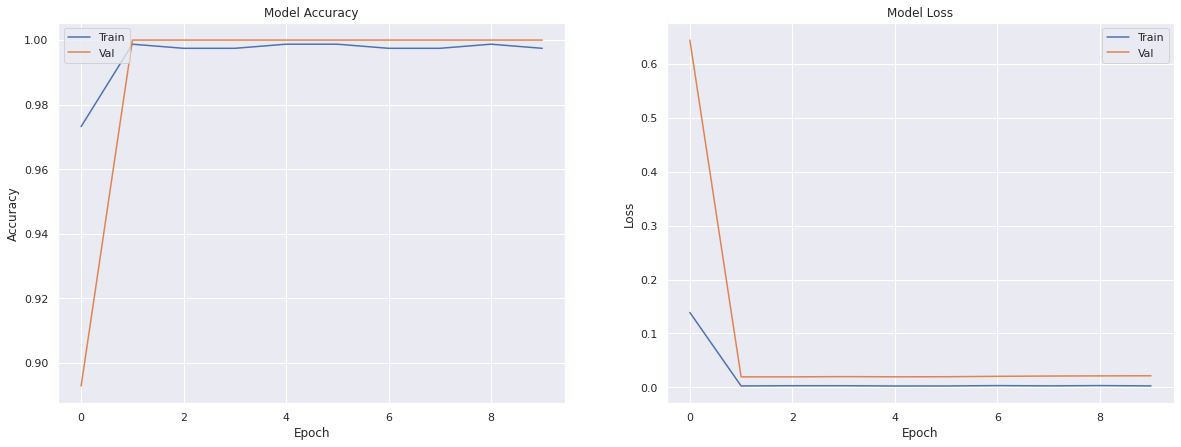

In [98]:
plotModelPerformanceCurvs(history)

In [62]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D

# Initialize the model
nnpmodel = Sequential()

# Add a Convolutional Layer with 32 filters of size 3X3 and activation function as 'relu' 
nnpmodel.add(Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,CHANNEL)))

# Add a Convolutional Layer with 32 filters of size 3X3 and activation function as 'relu' 
nnpmodel.add(Conv2D(filters=32, kernel_size=3, activation="relu"))

# Add a MaxPooling Layer of size 2X2 
nnpmodel.add(MaxPooling2D(pool_size=(2, 2)))

# Apply Dropout with 0.2 probability 
nnpmodel.add(Dropout(rate=0.2))

# Flatten the layer
nnpmodel.add(Flatten())

# Add Fully Connected Layer with 128 units and activation function as 'relu'
nnpmodel.add(Dense(128, activation="relu"))

#Add Fully Connected Layer with 196 units and activation function as 'softmax'
nnpmodel.add(Dense(196, activation="softmax"))

In [63]:
nnpmodel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 124, 124, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 62, 62, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 123008)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               15745152  
_________________________________________________________________
dense_2 (Dense)              (None, 196)              

In [64]:
nnpmodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [100]:
nnphistory=nnpmodel.fit( x=x_train, y=y_train_tensor, batch_size=10, epochs=10,shuffle=True,verbose=1,validation_split=0.2)

Epoch 1/10
79/79 [==============================] - 2s 25ms/step - loss: 0.0100 - accuracy: 0.9974 - val_loss: 8.4498e-04 - val_accuracy: 1.0000
Epoch 2/10
79/79 [==============================] - 2s 24ms/step - loss: 0.0042 - accuracy: 0.9987 - val_loss: 5.7479e-04 - val_accuracy: 1.0000
Epoch 3/10
79/79 [==============================] - 2s 23ms/step - loss: 0.0035 - accuracy: 0.9987 - val_loss: 5.0765e-04 - val_accuracy: 1.0000
Epoch 4/10
79/79 [==============================] - 2s 23ms/step - loss: 0.0032 - accuracy: 0.9987 - val_loss: 4.1567e-04 - val_accuracy: 1.0000
Epoch 5/10
79/79 [==============================] - 2s 24ms/step - loss: 0.0031 - accuracy: 0.9987 - val_loss: 3.2579e-04 - val_accuracy: 1.0000
Epoch 6/10
79/79 [==============================] - 2s 23ms/step - loss: 0.0023 - accuracy: 0.9987 - val_loss: 2.9562e-04 - val_accuracy: 1.0000
Epoch 7/10
79/79 [==============================] - 2s 23ms/step - loss: 0.0026 - accuracy: 0.9987 - val_loss: 2.8808e-04 - val_ac

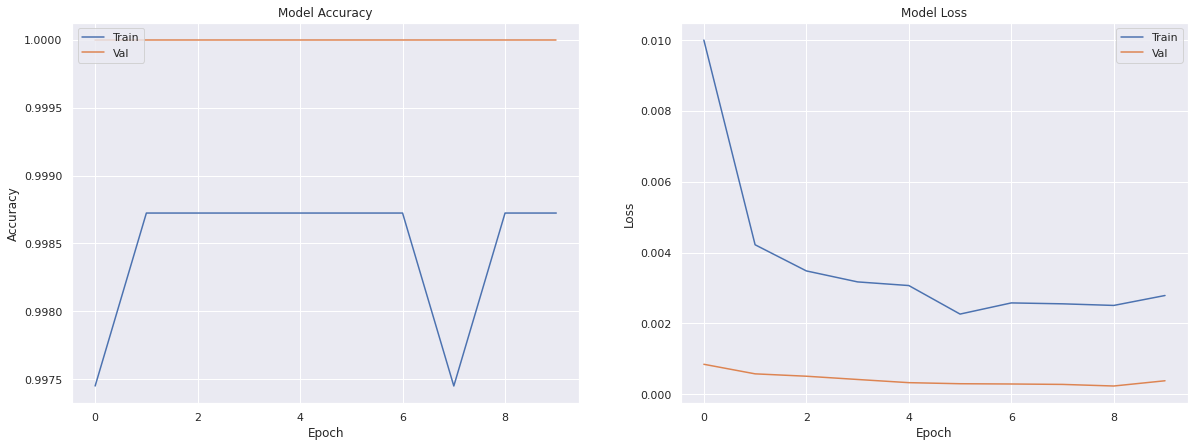

In [101]:
plotModelPerformanceCurvs(nnphistory)

### Final loss and accuracy

In [102]:
nnpmodel.evaluate(x_test, y_test_tensor)

31/31 [==============================] - 1s 43ms/step - loss: 10.3294 - accuracy: 0.0061


[10.329375267028809, 0.006122448947280645]

### creating bounding box labels

In [68]:
y_train=createBondingBoxTensor(trainReducedMergedImageDF,'x0_scaled','y0_scaled','x1_scaled','y1_scaled')
y_test=createBondingBoxTensor(testReducedMergedImageDF,'x0_scaled','y0_scaled','x1_scaled','y1_scaled')

In [69]:
y_train.shape

(980, 4)

In [70]:
y_test.shape

(980, 4)

### Create the model for bounding box predictions

In [71]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Reshape

ALPHA = 1.0 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower

def create_model(imgWidth,imgHeight,trainable=True):
    model = MobileNet(input_shape=(imgWidth, imgHeight, 3), include_top=False, alpha=ALPHA) # Load pre-trained mobilenet
    # Do not include classification (top) layer

    # to freeze layers, except the new top layer, of course, which will be added below
    for layer in model.layers:
        layer.trainable = trainable

    # Add new top layer which is a conv layer of the same size as the previous layer so that only 4 coords of BBox can be output
    x0 = model.layers[-1].output
    x1 = Conv2D(4, kernel_size=4, name="coords")(x0)
    # In the line above kernel size should be 3 for img size 96, 4 for img size 128, 5 for img size 160 etc.
    x2 = Reshape((4,))(x1) # These are the 4 predicted coordinates of one BBox

    return Model(inputs=model.input, outputs=x2)

### Define evaluation metric

In [72]:
def IOU(y_true, y_pred):
    intersections = 0
    unions = 0
    # set the types so we are sure what type we are using

    gt = y_true
    pred = y_pred
    # Compute interection of predicted (pred) and ground truth (gt) bounding boxes
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height

    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

    # Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
      if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
        intersections += intersection[j]
        unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + tensorflow.keras.backend.epsilon()), 4)
    # This must match the type used in py_func
    iou = iou.astype(np.float32)
    return iou

In [73]:
def IoU(y_true, y_pred):
    iou = tensorflow.py_function(IOU, [y_true, y_pred], Tout=tensorflow.float32)
    return iou

###  Initialize the model and print summary

In [74]:
model = create_model(IMAGE_WIDTH,IMAGE_HEIGHT,False) # Arg is False, if you want to freeze lower layers for fast training (but low accuracy)
model.summary() # Print summary

17227776/17225924 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
______________________________________________________________

### Compile the model
* loss: "mean_squared_error"
* metrics: IoU
* optimizer: "adam"

In [75]:
# Compile the model
model.compile(loss="mean_squared_error", optimizer="adam", metrics=[IoU]) # Regression loss is MSE
#model.compile(loss="mean_squared_error", optimizer="adam") # Regression loss is MSE

### Training the model
Fit the model to the dataset<br/>

* Use early stopping
* fit the model
* give train data - training features and labels
    ** batch size: 32
    ** epochs: 10
    ** give validation data - testing features and labels

In [76]:
pip install tensorflow-gpu==2.0.0-alpha0

     |████████████████████████████████| 332.5 MB 36 kB/s s eta 0:00:01   |███▏                            | 32.8 MB 1.6 MB/s eta 0:03:10     |███▌                            | 36.2 MB 1.6 MB/s eta 0:03:08     |████████████████                | 165.7 MB 7.8 MB/s eta 0:00:22     |█████████████████▉              | 185.6 MB 8.2 MB/s eta 0:00:18     |█████████████████████████▉      | 267.9 MB 5.2 MB/s eta 0:00:13     |██████████████████████████      | 269.5 MB 5.2 MB/s eta 0:00:13     |███████████████████████████▊    | 287.5 MB 5.0 MB/s eta 0:00:09     |███████████████████████████████▉| 330.7 MB 8.1 MB/s eta 0:00:01
     |████████████████████████████████| 50 kB 4.4 MB/s  eta 0:00:01
     |████████████████████████████████| 411 kB 9.9 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 9.9 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [77]:
import tensorflow
tensorflow.__version__

'2.4.1'

In [78]:
x_train[0]

array([[[0.92156863, 1.        , 0.84705883],
        [0.89411765, 1.        , 1.        ],
        [0.9137255 , 1.        , 1.        ],
        ...,
        [0.57254905, 0.64313728, 0.73725492],
        [0.57254905, 0.64313728, 0.73725492],
        [0.57647061, 0.63921571, 0.73725492]],

       [[1.        , 0.96862745, 1.        ],
        [1.        , 0.93333334, 0.95686275],
        [1.        , 0.97254902, 0.9254902 ],
        ...,
        [0.57254905, 0.64313728, 0.73725492],
        [0.57254905, 0.64313728, 0.73725492],
        [0.57647061, 0.63921571, 0.73725492]],

       [[1.        , 0.97647059, 1.        ],
        [1.        , 0.95294118, 0.90196079],
        [0.98431373, 0.95686275, 0.88627452],
        ...,
        [0.57254905, 0.64313728, 0.73725492],
        [0.57254905, 0.64313728, 0.73725492],
        [0.57647061, 0.63921571, 0.73725492]],

       ...,

       [[0.30980393, 0.32156864, 0.34117648],
        [0.30980393, 0.32156864, 0.34117648],
        [0.3137255 , 0

In [79]:
y_train[0]

array([  9.,  36., 120., 105.])

In [80]:
# Use earlystopping
callback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_IoU', patience=5, min_delta=0.01)

# Fit the model
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=32,callbacks=[callback])
#model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=32)

Epoch 1/10
31/31 [==============================] - 6s 141ms/step - loss: 2795.4468 - IoU: 0.2849 - val_loss: 243.5165 - val_IoU: 0.6735
Epoch 2/10
31/31 [==============================] - 4s 118ms/step - loss: 116.1242 - IoU: 0.7535 - val_loss: 84.1999 - val_IoU: 0.7727
Epoch 3/10
31/31 [==============================] - 4s 130ms/step - loss: 60.7926 - IoU: 0.8143 - val_loss: 67.8345 - val_IoU: 0.7922
Epoch 4/10
31/31 [==============================] - 4s 122ms/step - loss: 42.7470 - IoU: 0.8464 - val_loss: 62.5343 - val_IoU: 0.7964
Epoch 5/10
31/31 [==============================] - 4s 118ms/step - loss: 29.9465 - IoU: 0.8685 - val_loss: 59.5708 - val_IoU: 0.7988
Epoch 6/10
31/31 [==============================] - 4s 120ms/step - loss: 26.3191 - IoU: 0.8809 - val_loss: 57.1401 - val_IoU: 0.8020


### Final loss and accuracy

In [81]:
model.evaluate(x_test, y_test)

31/31 [==============================] - 2s 57ms/step - loss: 57.1401 - IoU: 0.8020


[57.140132904052734, 0.8019773960113525]

### Test the model on an image from test data

In [82]:
def drowPredictedBBOnImage(fileName,imgResizeTuple,imageArrayCol,colorScheme):
    df=loadSingleScoringImage(filename,imgResizeTuple,colorScheme)
    df[imageArrayCol]=df[imageArrayCol]/255
    predImageTensor=createFeatureTensor(df[imageArrayCol])
    region = model.predict(x=predImageTensor)[0] # Predict the BBox
    x0=region[0]
    y0=region[1]
    x1=region[2]
    y1=region[3]
    # Create figure and axes
    fig,ax = plt.subplots(1)
    # Display the image
    ax.imshow(df[imageArrayCol][0])
    # Create a Rectangle patch
    rect = patches.Rectangle((x0,y0),x1-x0,y1-y0, linewidth=2, edgecolor='b', facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
    plt.show()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


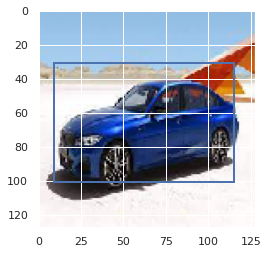

In [83]:
filename = '../input/customcarimages/bmw.jpg'
drowPredictedBBOnImage(filename,(IMAGE_WIDTH,IMAGE_HEIGHT,CHANNEL),'image_array','rgb')